# Import

In this notebook, I preprocess the sound textures from McDermott and Simoncelli (2011).

In [1]:
from scipy.io import wavfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import IPython  # to play audio
import glob
import torch
from functools import partial

from torch import nn, optim
from torch.nn import functional as F
from scipy.signal import spectrogram
import torchvision
import torchvision.transforms as TV
import torchaudio.transforms as AV


import matplotlib as mpl

import SETTINGS

mpl.rcParams.update({'font.size':         24,
                     'axes.linewidth':    3,
                     'xtick.major.size':  5,
                     'xtick.major.width': 2,
                     'ytick.major.size':  5,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':  "Arial",
                     'font.family':      "sans-serif",
                    })

########## Checks if path exists, if not then creates directory ##########
def check_path(basepath, path):
    if path in basepath:
        return basepath
    elif not os.path.exists(os.path.join(basepath, path)):
        os.makedirs(os.path.join(basepath, path))
        print('Added Directory:'+ os.path.join(basepath, path))
        return os.path.join(basepath, path)
    else:
        return os.path.join(basepath, path)

dataRootDir = SETTINGS.DATA_PATH
# Set up partial functions for directory managing
join = partial(os.path.join,dataRootDir)
checkDir = partial(check_path,dataRootDir)
FigurePath = checkDir('Figures')

savefigs=False



# Natural Sounds Dataset Curation

In [2]:
data_path = join("soundFiles/ESC-50-master")


In [64]:
data_files = sorted(glob.glob(os.path.join(data_path,'audio/*.wav')))
label_table = pd.read_csv(os.path.join(data_path, 'meta/esc50.csv'))
label_table["label_name"] = label_table.category + "_" + label_table.filename
label_table2 = label_table.drop(vals_to_pop)
label_table2["label_name"].to_csv(join("soundFiles/labels_esc50.csv"))



In [4]:
# example index to use for testing/visualization
exInd = 1
samplerate, data_temp = wavfile.read(data_files[exInd])

In [5]:
data_files[exInd]

'/Users/Matt/Desktop/Research/Murray/data/PredAudioData/soundFiles/ESC-50-master/audio/1-100038-A-14.wav'

In [6]:
# Initialize holder for waveforms
# sound_data = np.zeros((len(data_files),samplerate))
duration_of_sample = 5  # Time in seconds that the sounds last for
sound_data = np.zeros((len(data_files),samplerate*duration_of_sample))

for n, d in enumerate(data_files):
    samplerate, data_temp = wavfile.read(d)
    sound_data[n] = data_temp.copy()

(129, 1148)


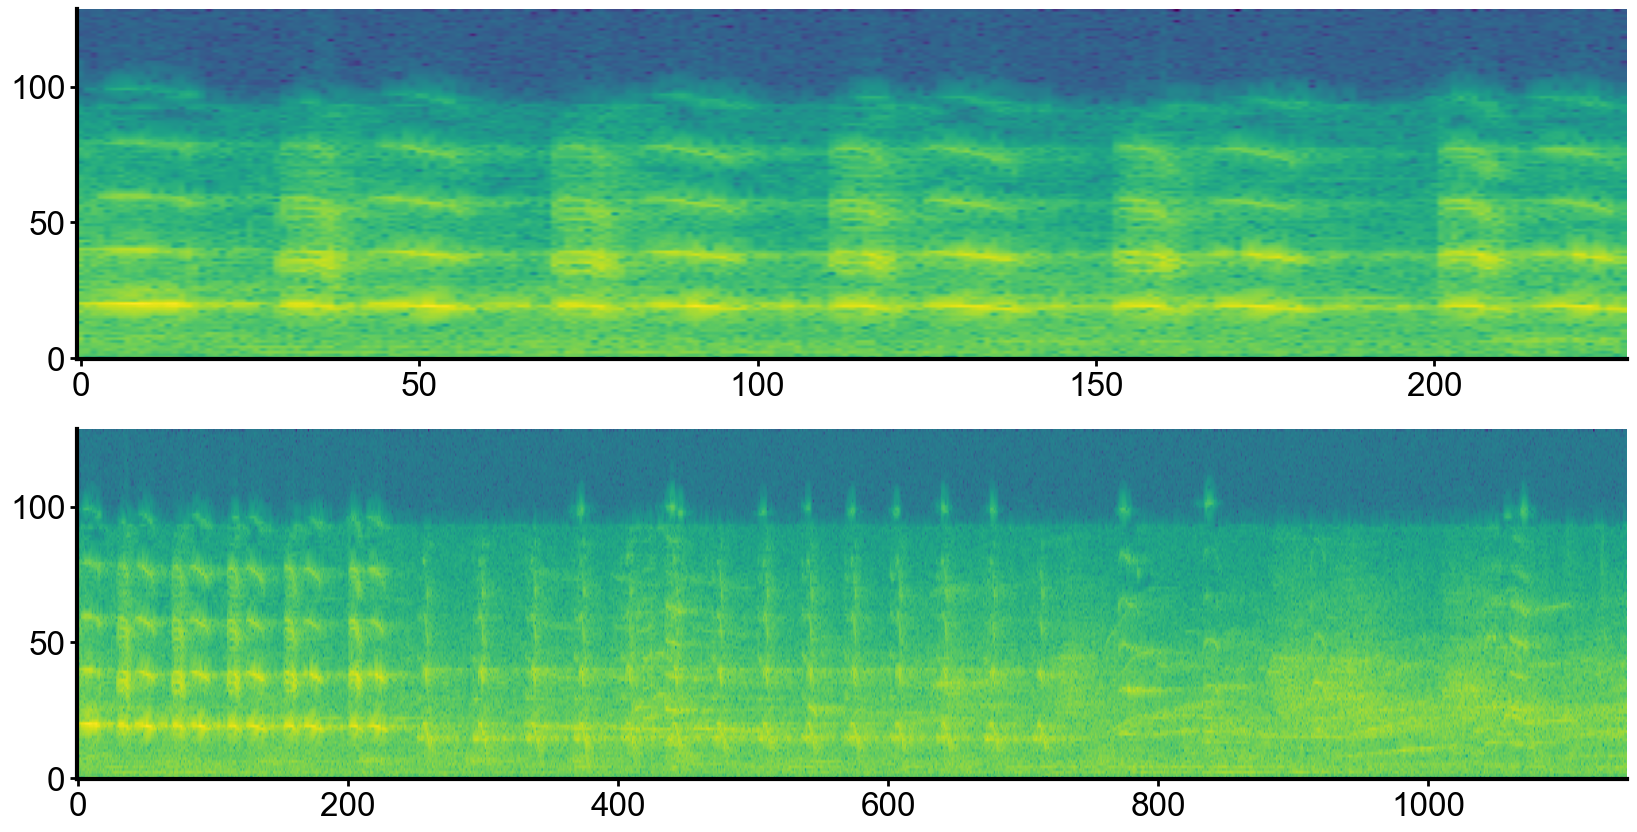

In [38]:
nf,nt = (128, 1148)  # (Number of frequencies, Number of time steps)
f_vals, t_vals, spec = spectrogram(sound_data[exInd], noverlap=nf//2)  # array of freqs, array of time segs, spectrogram
# f_vals, t_vals, spec = spectrogram(sound_data[exInd], noverlap=64)  # array of freqs, array of time segs, spectrogram
spec = np.log(1e-9 + spec)
print(spec.shape)
fig2, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].imshow(spec[:, :nt//5], aspect='auto', origin='lower')#, extent=(t_vals[0], t_vals[-1], f_vals[0], f_vals[-1]))  # Extent sets boundaries: left, right, bottom, top
axs[1].imshow(spec[:, :], aspect='auto', origin='lower')#, extent=(t_vals[0], t_vals[-1], f_vals[0], f_vals[-1]))  # Extent sets boundaries: left, right, bottom, top

In [39]:
nf,nt = (128, 512)  # (Number of frequencies, Number of time steps)
resize = TV.Resize((nf,nt))

# Initialize holder for spectrograms
data_spec = np.zeros((sound_data.shape[0],1,nf,nt))
for n in range(data_spec.shape[0]):
    f_vals, t_vals, spec = spectrogram(sound_data[n], noverlap=nf//2)
    spec = np.log(1e-9 + spec)
    reduced = spec.shape[1]//5
    spec2 = resize(torch.Tensor(spec)[:,:reduced].unsqueeze(0))
    data_spec[n,:] = spec2.numpy()


/Users/Matt/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


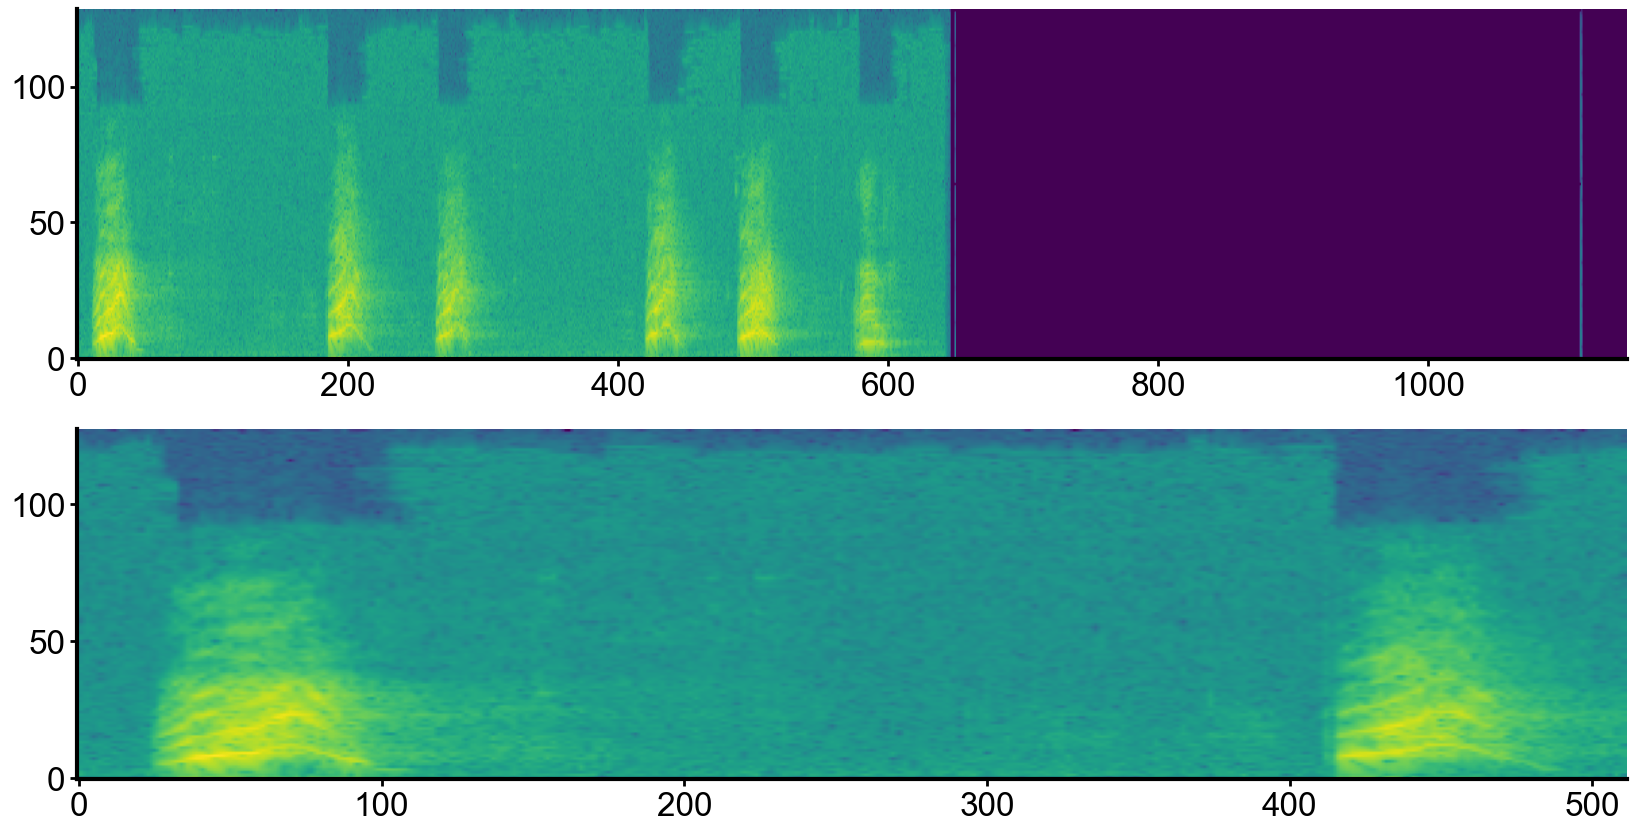

In [40]:
fig1, axs = plt.subplots(2, 1, figsize=(20, 10))
# axs[0].imshow(spec, aspect=samplerate, origin='lower', extent=(t_vals[0], t_vals[-1], f_vals[0], f_vals[-1]))
# axs[1].imshow(spec2[0], aspect=samplerate, origin='lower', extent=(t_vals[0], t_vals[-1], f_vals[0], f_vals[-1]))
axs[0].imshow(spec, aspect='auto', origin='lower')
axs[1].imshow(spec2[0], aspect='auto', origin='lower')

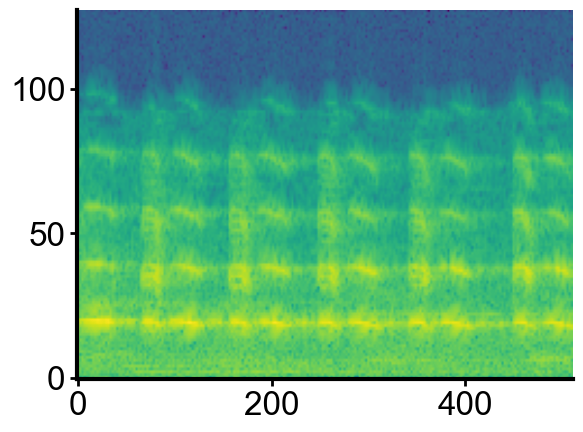

In [41]:
# plt.imshow(data_spec[exInd, 0], aspect=samplerate, origin='lower', extent=(t_vals[0], t_vals[-1], f_vals[0], f_vals[-1]))
plt.imshow(data_spec[exInd, 0], aspect='auto', origin='lower')

In [65]:
from sklearn.model_selection import train_test_split

spec_train, spec_test, labels_train, labels_test = train_test_split(data_spec2, label_table2["label_name"], train_size=0.8, random_state=1)

In [66]:
spec_train.shape, spec_test.shape

((1594, 1, 128, 512), (399, 1, 128, 512))

In [67]:
np.save(join('soundFiles/Specs_esc50_shortened.npy'),data_spec2)
np.save(join('soundFiles/Specs_train_esc50_shortened.npy'),spec_train)
np.save(join('soundFiles/Specs_test_esc50_shortened.npy'),spec_test)
pd.DataFrame(labels_train).to_csv(os.path.join(dataRootDir, "soundFiles/labels_train_esc50_shortened.csv"))
pd.DataFrame(labels_test).to_csv(os.path.join(dataRootDir, "soundFiles/labels_test_esc50_shortened.csv"))

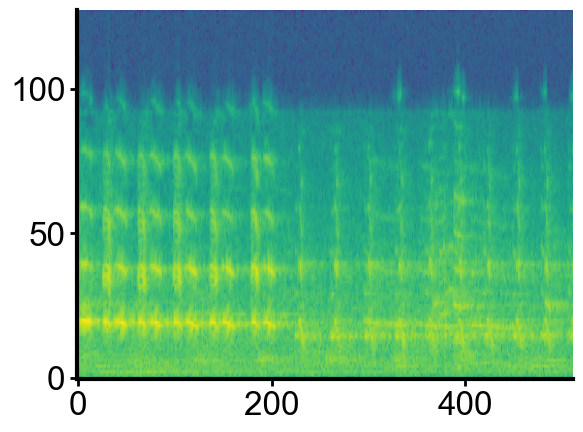

In [245]:
plt.imshow(data_spec[exInd,0], aspect='auto', origin='lower')#, extent=(t_vals[0], t_vals[-1], f_vals[0], f_vals[-1]))

## Sliding window testing

In [246]:
np.lib.stride_tricks.sliding_window_view(spec_train[exInd,0], window_shape=16, axis=-1)[:,:,:].shape

(128, 497, 16)

In [247]:
a = np.arange(10000).reshape(100,100)

In [236]:
wind_shape = 16
overlap = 16
wind_data = np.lib.stride_tricks.sliding_window_view(spec_train[exInd,0],window_shape=wind_shape,axis=-1)[:,::overlap,:].transpose(1,0,2).copy()

In [237]:
np.hstack(wind_data).shape

(128, 560)

In [36]:
idx = 6
data = spec_train.copy()
wind_size = 16
overlap = 14
sample = np.lib.stride_tricks.sliding_window_view(spec_train[idx,0],window_shape=wind_size,axis=-1)[:,::overlap,:].transpose(1,0,2).copy()
# sample = np.lib.stride_tricks.sliding_window_view(spec_train[idx,0],window_shape=wind_size,axis=-1)[:,:,:].transpose(1,0,2).copy()
# sample = np.zeros((data.shape[-1]//wind_size,data.shape[-2],wind_size))
# for n in range(data.shape[-1]//wind_size):
#     sample[n] = data[idx,:,:,(n*wind_size):(n*wind_size+wind_size)]

sample = (sample - np.min(sample))/(np.max(sample)-np.min(sample))
sample = np.clip(sample, 2e-30, 1).astype(np.float32)

In [37]:
sample.shape

(36, 128, 16)

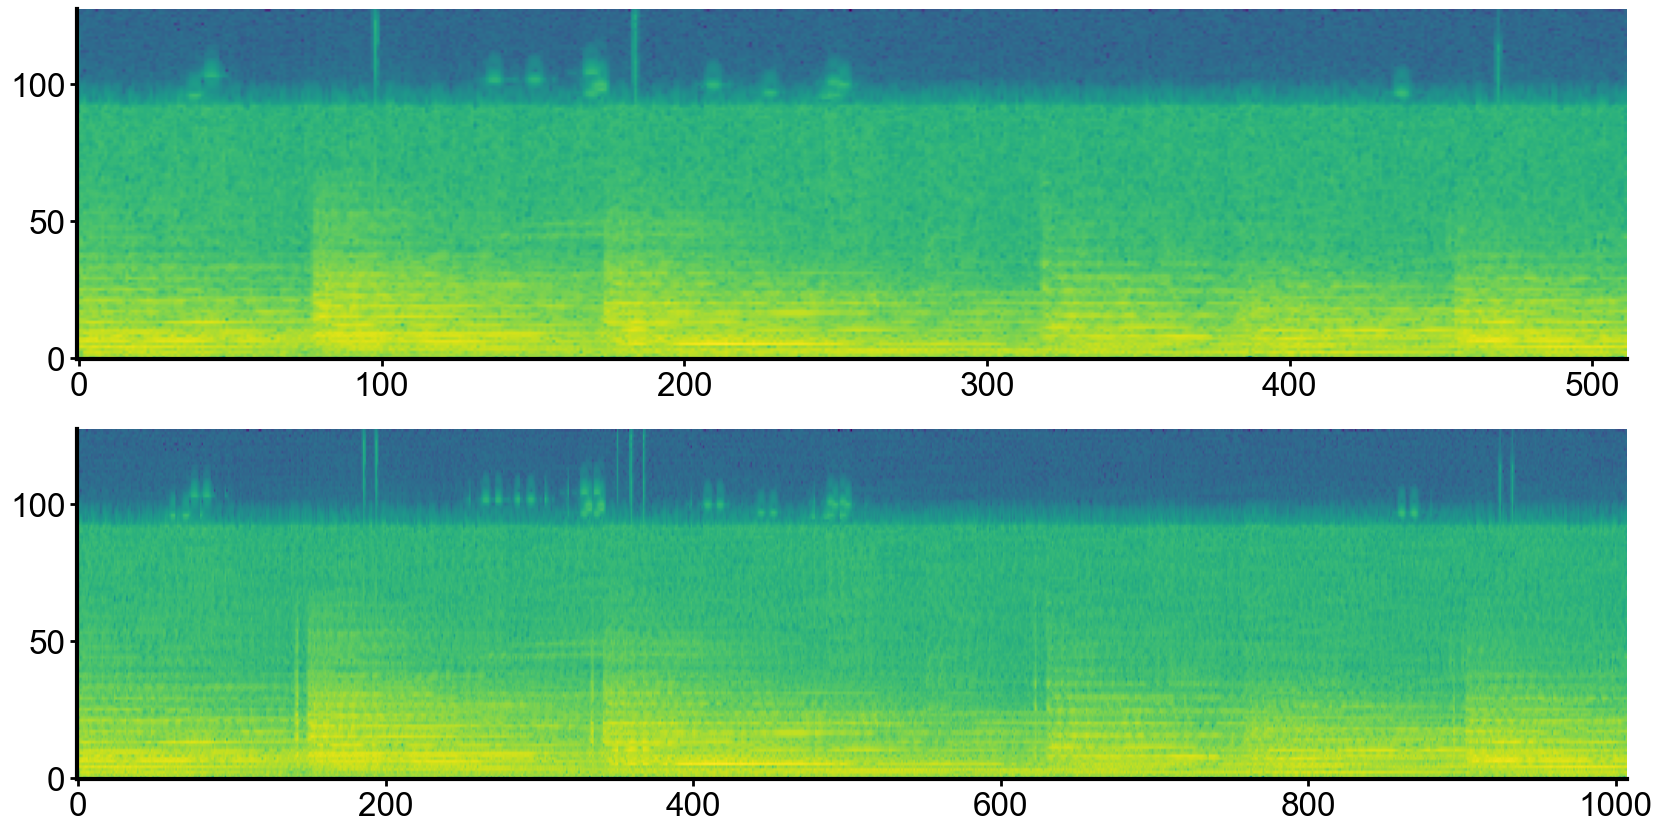

In [250]:
# plt.figure(figsize=(20,10))
fig2, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].imshow(spec_train[idx, 0], aspect='auto', origin='lower')#, extent=(t_vals[0], t_vals[-1], f_vals[0], f_vals[-1]))
axs[1].imshow(np.hstack(sample), aspect='auto', origin='lower')#, extent=(t_vals[0], t_vals[-1], f_vals[0], f_vals[-1]))

In [10]:
import warnings

In [61]:
data_spec2 = np.delete(data_spec2, gram, 0)

In [62]:
wind_size = 16
overlap = 12
with warnings.catch_warnings():
    warnings.simplefilter('error')
    for gram in range(data_spec2.shape[0]):
        sample = np.lib.stride_tricks.sliding_window_view(data_spec2[gram, 0],window_shape=wind_size,axis=-1)[:,::overlap,:].transpose(1,0,2).copy()
        sample = (sample - np.min(sample))/(np.max(sample)-np.min(sample))
        sample = np.clip(sample, 2e-30, 1).astype(np.float32)

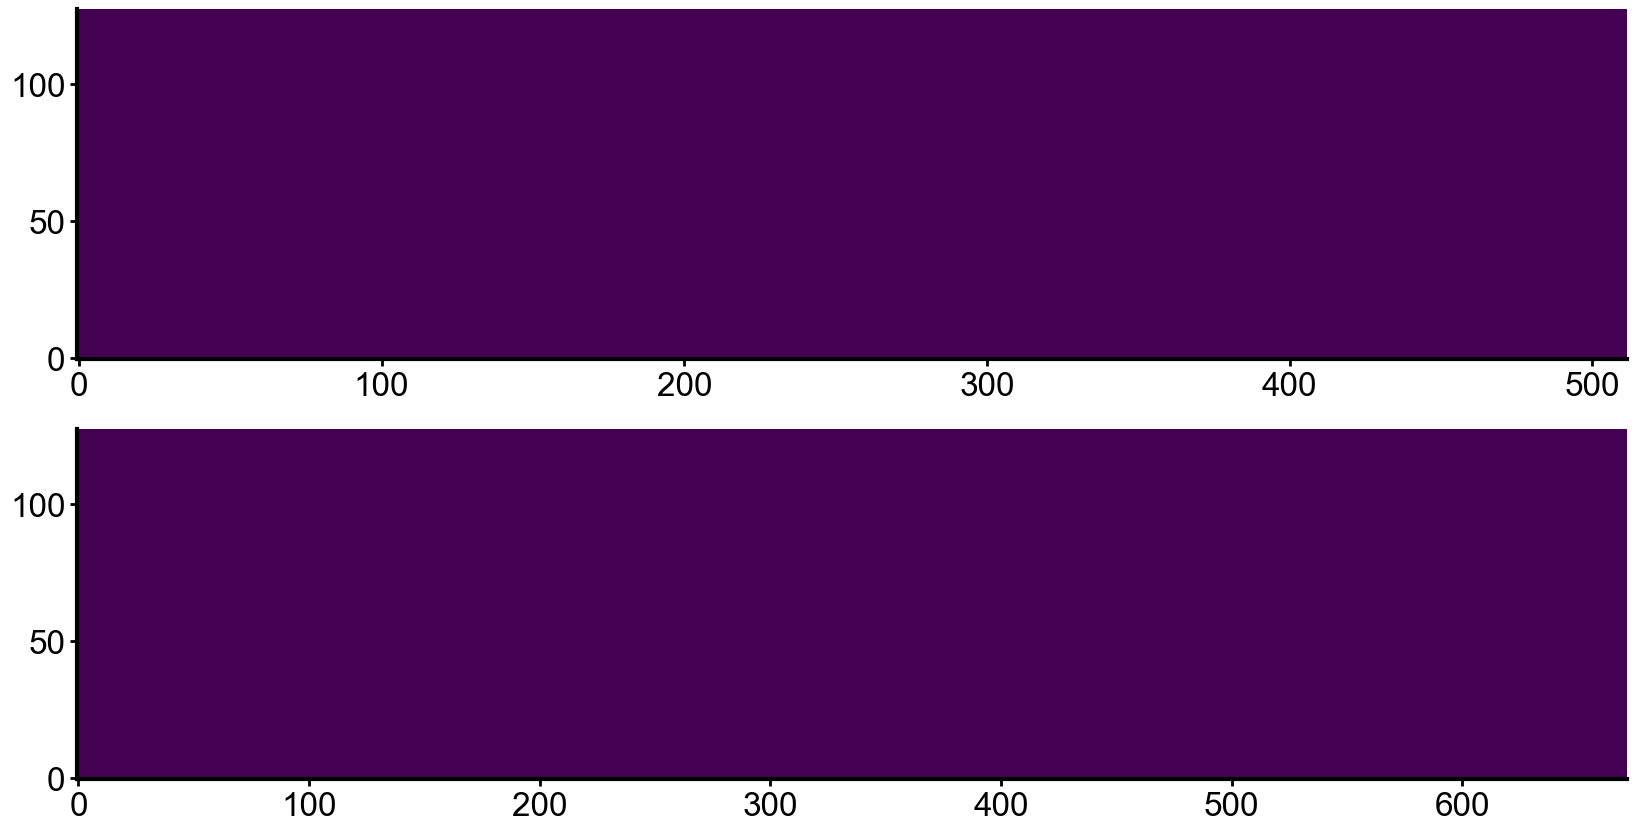

In [21]:
fig2, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].imshow(data_spec[gram, 0], aspect='auto', origin='lower')
axs[1].imshow(np.hstack(sample), aspect='auto', origin='lower')

In [63]:
vals_to_pop = [0, 416, 987, 1071, 1309, 1560, 1753]

In [ ]:
wind_size = 16
overlap = 12